<a href="https://colab.research.google.com/github/likhithaap/Car-damage-assesment-deep-learning-/blob/main/damageassesment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Setting up Detectron2**

In [1]:
!pip install -U torch torchvision
!pip install git+https://github.com/facebookresearch/fvcore.git
import torch, torchvision
torch.__version__

     |██████████████████████████████▎ | 834.1 MB 1.2 MB/s eta 0:00:40tcmalloc: large alloc 1147494400 bytes == 0x558551518000 @  0x7efeb1b31615 0x55854f5493bc 0x55854f62a18a 0x55854f54c1cd 0x55854f63eb3d 0x55854f5c0458 0x55854f5bb02f 0x55854f54daba 0x55854f5c02c0 0x55854f5bb02f 0x55854f54daba 0x55854f5bccd4 0x55854f63f986 0x55854f5bc350 0x55854f63f986 0x55854f5bc350 0x55854f63f986 0x55854f5bc350 0x55854f54df19 0x55854f591a79 0x55854f54cb32 0x55854f5c01dd 0x55854f5bb02f 0x55854f54daba 0x55854f5bccd4 0x55854f5bb02f 0x55854f54daba 0x55854f5bbeae 0x55854f54d9da 0x55854f5bc108 0x55854f5bb02f
     |████████████████████████████████| 881.9 MB 1.8 kB/s 
     |████████████████████████████████| 23.2 MB 1.3 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.11.1+cu111
    Uninstalling torchvisi

'1.10.2+cu102'

In [2]:
!git clone https://github.com/facebookresearch/detectron2 detectron2_repo
!pip install -e detectron2_repo

Cloning into 'detectron2_repo'...
remote: Enumerating objects: 13917, done.
remote: Total 13917 (delta 0), reused 0 (delta 0), pack-reused 13917
Receiving objects: 100% (13917/13917), 5.71 MiB | 11.11 MiB/s, done.
Resolving deltas: 100% (10059/10059), done.
Obtaining file:///content/detectron2_repo
     |████████████████████████████████| 74 kB 1.8 MB/s 
     |████████████████████████████████| 145 kB 11.7 MB/s 
     |████████████████████████████████| 130 kB 14.8 MB/s 
     |████████████████████████████████| 38.1 MB 1.3 MB/s 
     |████████████████████████████████| 749 kB 61.3 MB/s 
     |████████████████████████████████| 843 kB 36.0 MB/s 
     |████████████████████████████████| 112 kB 67.9 MB/s 
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.8-py3-none-any.whl size=141230 sha256=70d1788b1cf36c694926710affc8b0f246fe158dee1c9b9d031ef5fd916421b5
  Stored in directory: /root/.cache/pip/wheels/ca/33/b7/336836125fc9bb4ceaa4376d8abca10ca8bc84ddc824baea6c
Successf

In [1]:
# Some basic setup
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import matplotlib.pyplot as plt
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

Loading and registering the dataset to Detectron2

In [2]:
! unzip archive.zip

Archive:  archive.zip
  inflating: img/1.jpg               
  inflating: img/10.jpg              
  inflating: img/13.jpg              
  inflating: img/14.jpg              
  inflating: img/15.jpg              
  inflating: img/16.jpg              
  inflating: img/17.jpg              
  inflating: img/18.jpg              
  inflating: img/19.jpg              
  inflating: img/2.jpg               
  inflating: img/20.jpg              
  inflating: img/21.jpg              
  inflating: img/22.jpg              
  inflating: img/23.jpg              
  inflating: img/24.jpg              
  inflating: img/25.jpg              
  inflating: img/26.jpg              
  inflating: img/27.jpg              
  inflating: img/29.jpg              
  inflating: img/3.jpg               
  inflating: img/30.jpg              
  inflating: img/31.jpg              
  inflating: img/32.jpg              
  inflating: img/33.jpg              
  inflating: img/34.jpg              
  inflating: img/36.jpg     

In [3]:
#setting variables for all paths in the dataset 
#dataset_dir = "../input/coco-car-damage-detection-dataset"
img_dir = "/content/img"
train_dir = "/content/train"
val_dir = "/content/val"

In [4]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train", {}, "/content/train/COCO_train_annos.json", "/content/train")
register_coco_instances("my_dataset_val", {}, "/content/val/COCO_val_annos.json", "/content/val")

In [5]:
dataset_dicts = DatasetCatalog.get("my_dataset_train")
metadata_dicts = MetadataCatalog.get("my_dataset_train")

[03/06 16:21:52 d2.data.datasets.coco]: Loaded 59 images in COCO format from /content/train/COCO_train_annos.json


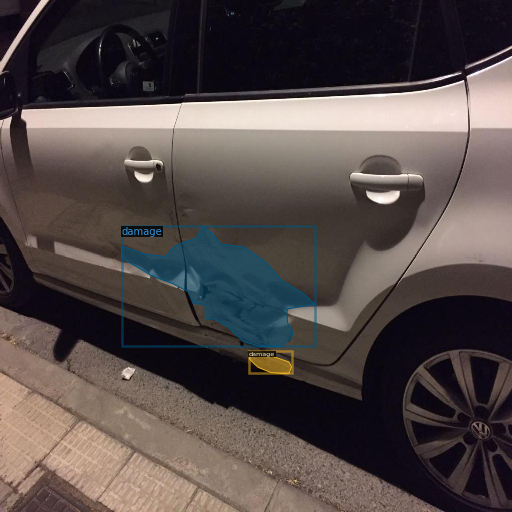

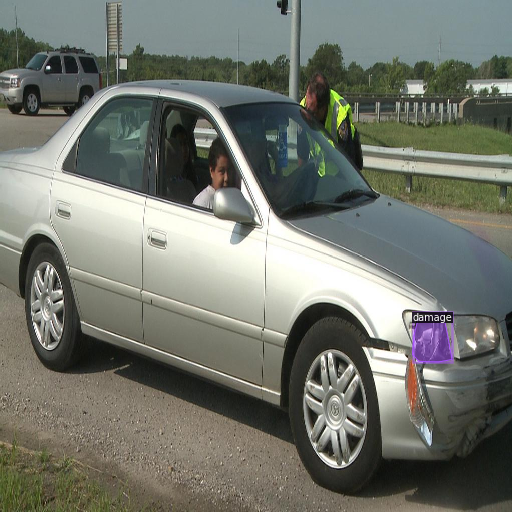

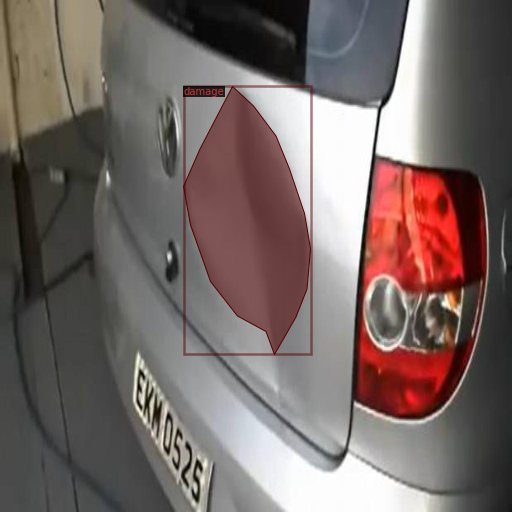

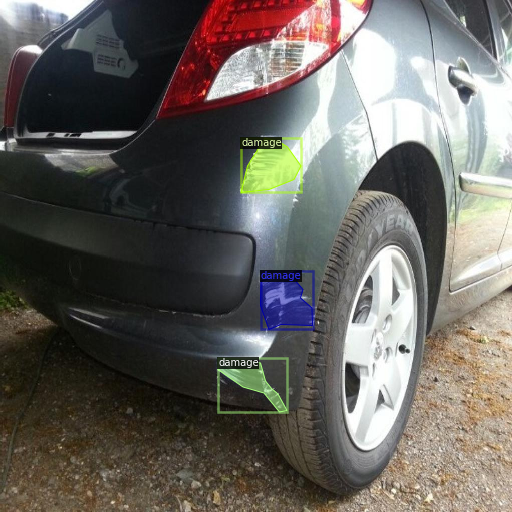

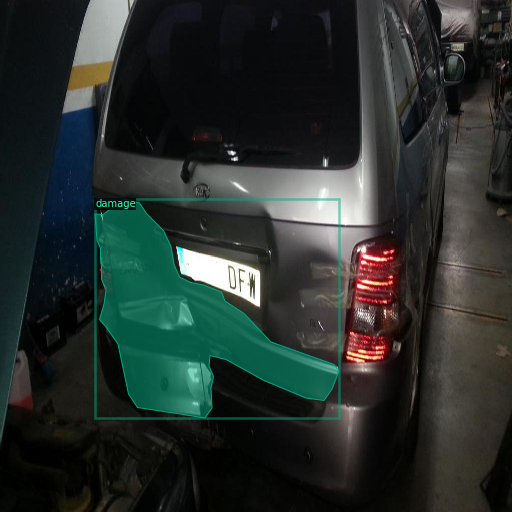

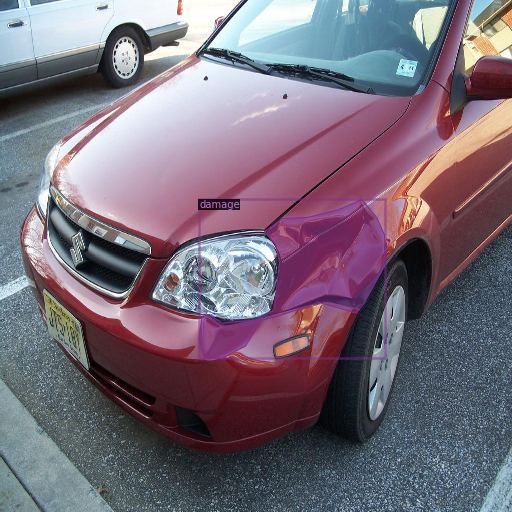

In [6]:
import random

for d in random.sample(dataset_dicts, 6):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=metadata_dicts, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])


In [7]:
from detectron2 import model_zoo
import os

In [8]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_val")   
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")# initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.001
cfg.SOLVER.MAX_ITER = 300   # 300 iterations seems good enough, but you can certainly train longer
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2  # 3 classes (Person, Helmet, Car)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=True)
trainer.train()

RuntimeError: ignored